# COMP-4360 - Machine Learning - Assignment 1 - Project

## Instructions

| Date set     | Hand-in date |
|------------------|-----------------------------------|
|6 October 2022  | **23 October 2022** |



Your report should consist of your Jupyter notebook showing what you did (including technical descriptions of the implemented algorithms), what was the result and what you can conclude from the experiments. Each report will be
assessed on the following criteria:

* Does it record what was done including the details of the implemented algorithms?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

Use markdown to explain what you are doing (including equations for models and algorithms), what the results mean, how they relate to the theory, etc. For learning jupyter notebooks, you may refer to this guide: https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook

<div class="alert alert-warning">
Although you will undoubtedly work collaboratively, these are individual exercises. The notebook you write should be about the results you obtained, and your attention is drawn to the University guidelines on collaboration and plagiarism. 

## Project specification

Implement a standard echo state network (ESN) model as discussed in class. Do not include feedback from the output and do not use leaky-integrator neurons. Implement training of the read-out weights by means of ridge regression. Perform experiments and comment the results by considering a _k_ step ahead forecasting task on the "2sine" and "lorentz" time series data provided to you together with this notebook. Evaluate the impact of relevant hyper-parameters on the results, including the reservoir size and the amount of training data used for optimizing the read-out weights. Finally, discuss the effects of using different forecasting horizons on the overall performance of the model. **Note:** it is possible to consider the impact of additional hyperparameters, like the spectral radius of the reservoir matrix, and this will give you some extra points.

### K step ahead forecasting
A _k_ step ahead forecasting task consists of predicting the value of a time series at time $t+k$ by using the value of the time series at time $t$, where $k\geq1$ is called forecasting horizon.
In general, the predicted value is always unidimensional (i.e. a single number). However, it is possible to use multiple input values in order to improve the results. Notably, once _k_ is decided, the output to be predicted is the value of the time series at time $t+k$, and the input may be a vector containing values of the times series at time $t, t-1, \dots, t-n$, where $n\geq0$ is defined by the user and sets the dimensionality of the input vector.

## Your project starts from here!

In [16]:
import matplotlib.pyplot as plt
# make sure plots are correctly displayed in the notebook
%matplotlib inline
import numpy as np

### Helper Functions
* **split_data()**: calculates and returns the indexes of the last element in the split dataset using the percentages (t_amt, v_amt, te_amt) passed-in. This function is used during all stages to assign training data, validation data, and testing data.
* **concat_data()**: used after **split_data()**. Essentially creates a deep copy of the original data into each dataset (training, validation, testing).
* **search()**: sorts the given array of tuples in ascending order and returns the sorted list. This function is used during the validation stage, specifically when finding the lowest mean-square error and associated hyperparameter.

In [17]:
#returns the last index of each section of data
def split_data(data, t_amt, v_amt, te_amt):
    #x%  of data is len(data)*x / 100
    train = int((len(data)*t_amt )/ 100)
    validate = int((len(data)*v_amt)/100)
    test = int((len(data)*te_amt)/100)
    #print(train, validate, test)
    return train, validate, test

#sorts given list in ascending order
def search(list: np.array):
    temp = 0
    for i in range(1,len(list)):
        if list[i][0] < list[temp][0]:
            temp = i
    return temp

#creates deep copies of sub-data (ie training/valid/testing) from original data
def concat_data(data, start, end):
    newarray = np.zeros(end)
    for x in range(end):
        newarray[x] = data[start]
        start+=1
    return newarray


## Training the Model
The model is trained on the training dataset, using _input_weights_, _recurr_weights_ and the _Nr_. The training stage consists of finding the states of the training data and the calculating the optimized weights using ridge regression. **Batch Training** is used meaning that all the states are calculated before optimizing the weights.
### Definitions
* **_training_data_**: derived from the original data passed into the **run()** function. It is then split into sections (based on parameters): training, validating, and testing.
* **_Nr_**: defines the number of hidden layer neurons. As it is a hyperparameter, it is optimized later during cross-validation. In this stage, it is passed in the **run()** function call.
* **_input_weights_**: input weights (W^i) are randomly distributed on the interval $(-1,1)$. This random distribution is done using **np.random.uniform()** function. As in the standard ESN model, $W^i \in \mathbb{R}^{NrxNi}$, where Nr is the number of neurons in the hidden layer and Ni is the dimensionality of the input (in this case, it's 1)
* **_recurr_weights_**: defines the weights of the hidden layer neurons (W^r). Like _input_weights_, these weights are randomly distributed on the interval $(-1,1)$ using **np.random.uniform()**. As in the definition of the standard ESN model, $W^r \in \mathbb{R}^{NrxNr}$, where Nr is the number of neurons in the hidden layer.
* Activation function: states will be calculated using a logistic activation function, **sigmoid**. The **sigmoid()** function is defined as $x = 1/(1+np.exp(-x))$
### Process
 Once the data is split, the training dataset is  passed to the **train_model()** function, which uses the **calc_ESP()** function to calculate the states.
 During **calcESP()**:
 * The state matrix, _statrix_, is defined as the vector of states 0 to Nr. The first state (ie state at 0) is 0.
 * For each element $t \in {1,...,N}$ in the training dataset, we calculate the state at t using: $X_t = sigmoid(W^r \cdot X_{t-1} + W^i \cdot U_t)$, where W^r is the recurrent layer weights, X_{t-1} is the previous state, W^i is the input weights, and U_t is the data at time t (given by the parameter training_data).
 * **calcESP()** returns the state matrix

Next, the weights are optimized using **ridge regression**. Using this regularized version of the least-square problem allows us to reduce the magnitude of the weights (both input and recurrent) and make our model less sensitive to overfitting.  The **train_model()** function calls the  **ridge_regression()** function, defined below.
During **ridge_regression()**:
 * We calculate the optimized weights using the parameters given: _statrix_ which is the state matrix from **calcESP()**, _targets_ which is the original training data, _Nr_ which is the number of neurons in the hidden layer, and _lambda_ which is the regularization parameter. Note that _lambda_ is a hyperparameter and will be optimized during cross-validation.
* Ridge regression is defined as: $W^o = (X^\intercal \cdot X + \lambda I)^{-1} \cdot X^\intercal \cdot t$, where X is the state matrix, $\lambda$ is the regularization parameter, I is an NrxNr identity matrix, and t is the vector of targets.
* The optimized weights, $W^o$ are returned.

In [18]:
#declaration of the sigmoid activation function
def sigmoid(value):
    return 1/(1+np.exp(-value))

In [19]:
#calculates states using sigmoid activation function, returns the state matrix for training_data
def calcESP(training_data, input_weights, recurr_weights, Nr):
    #initalize state-matrix (Nrx1) to an array of 0s
    statrix = np.transpose(np.zeros((Nr,1))) # need to transpose because of the way np.zeros works
    #calculate states from 1-timestep t
    for t in range(1,len(training_data)):
        Ut = training_data[t-1]
        input_data_dot = np.dot(input_weights,Ut)
        recurr_state_dot = np.dot(recurr_weights, np.transpose(np.array([statrix[t-1]])))
        activation = sigmoid(recurr_state_dot + input_data_dot)
        #update state matrix
        statrix = np.concatenate((statrix, np.transpose(activation)),axis=0)
    return statrix

In [20]:
#optimizes the weights using ridge regression, and returns them
def ridge_regression(statrix, targets, Nr, _lambda):
    #create NrxNr identity matrix -- can only be added to the squared state matrix if its an (Nr*2)x(Nr*2) matrix
    identity = np.identity(Nr)
    #Wo is a NoxNr matrix, where No is the number of output dimensions and Nr is the number of neurons in the hidden layer
    Wo = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(statrix),statrix)+(_lambda*identity)), (np.transpose(statrix))),targets)
    return Wo

## Cross-Validation
Once the model has been trained on the training dataset, we perform cross-validation on the validation dataset. In this stage, we optimize hyperparameters and evaluate the mean-square error of the model. We specifically optimize Nr, _lambda (which is the regularization parameter), and the amount of training data. Additionally, I assume that the process of training-validation-testing is linear meaning that I use the optimal hyperparameters found in the validation stage for all k-step predictions. In other words, once the optimal hyperparameters are found for 1-step ahead prediction, I don't return to the validation stage to find the optimal hyperparameters for subsequent k-step ahead predictions. Hyperparameters are kept consistent, although they are calculated for each timeseries dataset (2sin, lorenz).
### Mean-square Error Calculation
All calculations of mean-square error use the **MSE()** function. The equation: $1/N \sum_{1}^{N} (targets[kstep:]-predicted)^2$, where N is the length of the targets, predicted is the array of prediction values, and the targets is a vector from kstep to N.
### Process
Firstly, we optimize the number of neurons in the hidden layer, _Nr_. This is done using the **optimizeNr()** function. For this function, we pass in a predefined list of possible Nr values and loop through this list, calculating the 1-step ahead prediction and evaluating the associated mean-square error. Note that the regularization parameter is an unoptimized value. The Nr and associated mean-square error are stored in an array of tuples (e,Nr). Additionally, e and Nr are stored in the ycoord and xcoord arrays respectively, for graphing purposes. After the **optimizeNr()** function completes, the tuple array returned is sorted in ascending order using the **search()** function (defined in the Helper Functions section previous) and the optimal Nr value is now at the first position in the array.

Secondly, we optimize the regularization parameter, _lambda_ using the **optimizel()** function, which basically operates the same as the **optimizeNr()** function. A predefined list of possible regularization parameters is passed in and loop through the list, calculating the 1-step ahead prediction and associated mean-square error. Since Nr has already been optimized, the optimized Nr value is used in calculating the optimal lambda. Again, this is stored in an array of tuples (e,lambda) and each e and lambda is stored in ycoord, xcoord arrays respectively. The function returns the tuple array, and it is sorted in ascending order, which means the tuple in the first position contains the optimal lambda.

Lastly, we optimize the amount of training data used to train the model. The amount validation and testing data changes according to the amount of training data used. Since we have already optimized Nr and lambda, we can use them in the optimization of the training data. To optimize, we call the **run()** function using different amounts of data and passing in a flag indicating that the optimized Nr and lambda need to be used.

Results will be examined in the corresponding **Results: 2Sine/Lorenz Timeseries Data** section towards the end of the notebook.


In [41]:
def optimizel(val,s_l, Nr,kstep):
    tuples = np.zeros((len(val),2))
    xcoords = np.zeros(len(val))
    ycoords = np.zeros(len(val))

    for i in range(len(val)):
        x = run(s_l,60,20,20,Nr,val[i],1,kstep)
        xcoords[i] = val[i]
        ycoords[i] = MSE(x[0],x[1],kstep)
        tuples[i] = (ycoords[i],xcoords[i])
    fig = plt.figure(figsize=(10, 6))
    plt.title('Optimize Lambda')
    plt.plot(xcoords,ycoords, c='m')
    plt.xlabel ('Lambda Values')
    plt.ylabel ('Mean-Square Error')
    #plt.legend()
    plt.show()
    return tuples

In [42]:
def optimizeNr(val,s_l, _lambda,kstep):
    tuples = np.zeros((len(val),2))
    xcoords = np.zeros(len(val))
    ycoords = np.zeros(len(val))

    for i in range(len(val)):
        x = run(s_l,60,20,20,val[i],_lambda,1,kstep)
        xcoords[i] = val[i]
        ycoords[i] = MSE(x[0],x[1],kstep)
        tuples[i] = (ycoords[i],xcoords[i])
    fig = plt.figure(figsize=(10, 6))
    plt.title('Optimized Nr')
    plt.plot(xcoords,ycoords, c='m')
    plt.xlabel ('Nr Values')
    plt.ylabel ('Mean-Square Error')
    #plt.legend()
    plt.show()
    return tuples

## K-Step Ahead Prediction
### Mean-Square Error
All calculations of mean-square error use the **MSE()** function. The equation: $1/N \sum_{1}^{N} (targets[kstep:]-predicted)^2$, where N is the length of the targets, predicted is the array of predicted values, and the targets is a vector from kstep to N.
### Process
K-step ahead prediction is used in both the validation and testing stages on different sets of data. As described in the **Cross-Validation** section above, it's using 1-step ahead prediction to evaluate the mean-square error of each hyperparameter. In the **testing stage**, the testing dataset is used to do k-step ahead prediction, where k is values other than 1. The **run()** function is called with _flag=2_, indicating that the model is being tested.
In the **prediction()** function:
* The optimized values W^o, Nr are passed in as well as the testing data, input_weights, recurr_weights, and the k-step.
* The prediction array _prediction_k_ is size $len(prediction_k - kstep)$ (since we're predicting kstep ahead of the current timestep), and stores all predictions at $t+kstep$.
* For each index in the prediction array _prediction_k_, re-initialize the state matrix _statrix_ and calculate the current state using the **state()** function, which returns $X = sigmoid(W^r \cdot pstate + W^i \cdot data)$, where W^r is the recurrent layer weights, pstate is the previous state passed in, W^i is the input weights, and data is the data passed into the function. This is essentially the same calculation as in **calcESP()** but it only calculates 1 state instead of an array of states.
* Once _statrix_ is updated, we loop kstep times.
    * In each loop, we make a prediction using: $Z_t = W^o \cdot X_t$, where $Z_t$ is the prediction at the current time, W^o is the optimized weights, and $X_t$ is the state at the $j+1$ kstep
    * Each iteration of the loop checks if $(j-1) = kstep$, if it is then the prediction calculated is the kstep ahead prediction and is added to the _prediction_k_ array, and this loop ends. Otherwise, we calculate and store the next state using the **state()** function, where we pass in the _prediction_k[i]_ in place of data, and _statrix[j+1]_ instead of _statrix[0]_.
* Once all the predictions have been calculated, they are returned.

Since **run()** returns the model (which in this case is the kstep ahead predictions) and the data (testing data here), we can calculate the mean-square error of the model using k-step ahead prediction.


In [43]:
#calculates a single state used when doing kstep prediction
def state(data, pstate, input_weights,recurr_weights):
    input_data_dot = np.dot(input_weights,data)
    recurr_state_dot = np.dot(recurr_weights, np.array(np.transpose([pstate])))
    activation = sigmoid(recurr_state_dot + input_data_dot)
    return activation

In [44]:

#handles kstep-ahead prediction in the validation and testing stages
def prediction(Wo, Nr, data, input_weights, recurr_weights, kstep):
    prediction_k = np.zeros(len(data)-kstep)
    for i in range(len(prediction_k)):
        #each time we look for the kstep ahead prediction, reset the state matrix
        statrix = np.transpose(np.zeros((Nr,1)))
        #calculate current state using the single state calculator: state()
        s = state(data[i],statrix[0],input_weights,recurr_weights)
        #update statrix
        statrix = np.concatenate((statrix, np.transpose(s)),axis=0)
        #predict k-steps ahead:
        for j in range(kstep):
            predic = np.dot(Wo,np.transpose(np.array(statrix[j+1])))
            #check for prediction at k --> add this to the prediction_k array
            if j==kstep-1:
                prediction_k[i] = predic
                break
            #using the predic,  calculate the next state and store it
            s = state(prediction_k[i],statrix[j+1],input_weights,recurr_weights)
            statrix = np.concatenate((statrix, np.transpose(s)),axis=0)
    return prediction_k

In [45]:
#Calculate error using Mean-Squared Error
def MSE(predicted, targets,kstep):
    return (np.sum((targets[kstep:]-predicted)**2))/len(targets)

In [46]:
#Train model using Echo State Property and Batch training
#Once trained, we optimize the weights
def train_model(training_data, data, Nr,_lambda,predicting,kstep):
#Define Weights
    #Wi (input weights) is a randomly initialized NrxNi matrix, uniformly distributed randomly on [-1,1]
#set RNG
    np.random.seed(42)
    input_weights = np.random.uniform(-1,1,(Nr,1))
    #Wr (recurrent layer weights) is a randomly initilized NrxNr matrix, uniformly distributed randomly on [-1,1]
    recurr_weights = np.random.uniform(-1,1,(Nr,Nr))
    #Calculate states for given data and unoptimized weights
    statrix =  calcESP(training_data, input_weights,recurr_weights,Nr)
    #Optimize weights using ridge regression
    Wo = ridge_regression(statrix, training_data,Nr, _lambda )
    #flag 'predicting' determines if we're testing the model, else we return information needed to perform cross-validation
    if predicting == 1 :
       return prediction(Wo, Nr, data, input_weights,recurr_weights,kstep)
    else:
        return  Wo, input_weights,recurr_weights

In [47]:
#Splits data into sections, trains and returns model
def run(data, t_amt, v_amt, te_amt, Nr, _lambda, flag,kstep):
    #Calculate indexes to split on from given percentages
    spl = split_data(data, t_amt, v_amt, te_amt)
    training_data = concat_data(data,0,spl[0])
    validate_data = concat_data(data,spl[0],spl[1])
    testing_data = concat_data(data, spl[1],spl[2])
    #using flag, determine if we're training, validating or testing model
    if flag==0:
         #plot the training data
        fig = plt.figure(figsize=(10,6))
        plt.plot(training_data,c='m')
        plt.title('Original Training Data')
        plt.xlabel('Timestep')
        plt.ylabel('Timeseries Data')
        plt.show()
        #model = train_model()
        return 1
    if flag == 1:
        #optimizing data amount
        model = train_model(training_data, validate_data,Nr, _lambda,1,kstep)
        return model, validate_data
    if flag == 2:
        #print('Testing Model')
        #train the testing data: includes finding states, optimizing weights and making k-step ahead predictions
        model = train_model(training_data,testing_data,int(Nr),_lambda,1,kstep)
        return model, testing_data



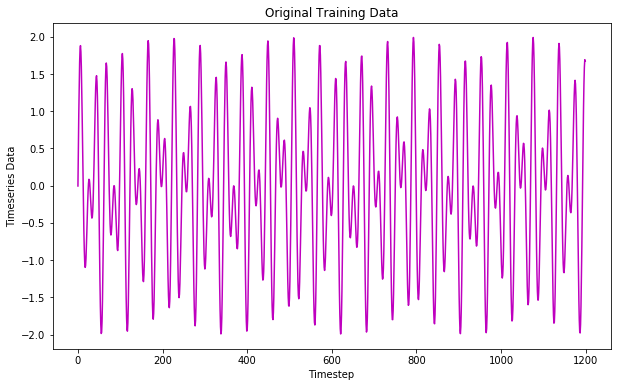

1

In [48]:
#------------SIN EXPERIMENT------------------
#Load data
sin2 = np.loadtxt('2sin.txt')
#start with a 60/20/20 split, 50 hidden neurons, 0.5 regression parameter, flag is 0 because we're training the model
run(sin2, 60,20,20,50,0.5,0,1)


## Results: 2Sine Timeseries Data

### Evaluation of Trained Model
The model is trained with 50 hidden neurons and a regularization parameter of 0.5. The above graph depicts the training data.

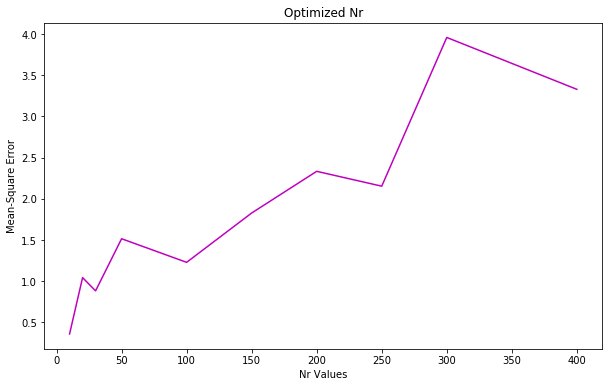

All tuples for Nr optimization:  [[3.60028738e-01 1.00000000e+01]
 [1.04414962e+00 2.00000000e+01]
 [8.83519266e-01 3.00000000e+01]
 [1.51610492e+00 5.00000000e+01]
 [1.22963826e+00 1.00000000e+02]
 [1.82844995e+00 1.50000000e+02]
 [2.33450136e+00 2.00000000e+02]
 [2.15407759e+00 2.50000000e+02]
 [3.95941187e+00 3.00000000e+02]
 [3.33003383e+00 4.00000000e+02]]
Best Nr value:  10


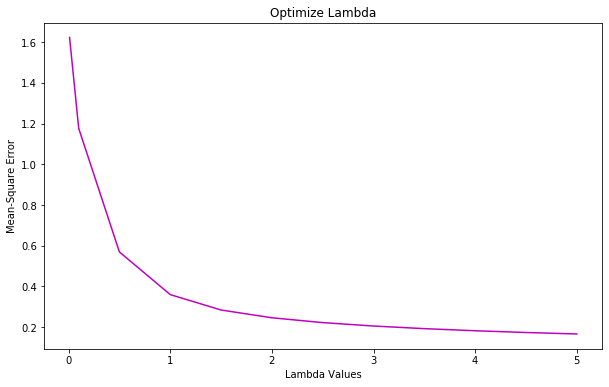

All tuples for lambda optimization:  [[1.62263751 0.01      ]
 [1.17628142 0.1       ]
 [0.56949986 0.5       ]
 [0.36002874 1.        ]
 [0.2842967  1.5       ]
 [0.2461427  2.        ]
 [0.22240638 2.5       ]
 [0.20559984 3.        ]
 [0.19273194 3.5       ]
 [0.18239293 4.        ]
 [0.17382372 4.5       ]
 [0.16656976 5.        ]]
Best lambda value:  5.0
0.13823015737859454
0.1527047315110582
0.16656976342391427
0.17290115270184073
0.17166004919631356


In [50]:
#Validate data - find the optimal hyperparameters (Nr, _lambda, amount training data); note that the flag is now 1 because we are validating Nr and lambda
#optimized = run(sin2, 60,20,20,50,0.1,1,1)
#optimize NR
pre_nr = [10,20,30,50,100,150,200,250,300,400]
tuples = optimizeNr(pre_nr,sin2,1,1)
print('All tuples for Nr optimization: ',tuples)
#tuples = r_nr[0]
#sort tuples asc
Nr = tuples[search(tuples)]
print('Best Nr value: ',int(Nr[1]))
#optimize lambda
alpha = [0.01,0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
tuples = optimizel(alpha,sin2,int(Nr[1]),1)
print('All tuples for lambda optimization: ',tuples)
#sort tuples asc
lam = tuples[search(tuples)]
print('Best lambda value: ',lam[1])
#optimize data split using optimized Nr and _lambda - flag is 1
od1 = run(sin2,40,30,30,int(Nr[1]),lam[1],1,1)
print( MSE(od1[0],od1[1],1))
od2 = run(sin2,50,30,20,int(Nr[1]),lam[1],1,1)
print( MSE(od2[0],od2[1],1))
od3 = run(sin2,60,20,20,int(Nr[1]),lam[1],1,1)
print( MSE(od3[0],od3[1],1))
od4 = run(sin2,70,15,15,int(Nr[1]),lam[1],1,1)
print( MSE(od4[0],od4[1],1))
od5 = run(sin2,80,10,10,int(Nr[1]),lam[1],1,1)
print( MSE(od5[0],od5[1],1))



### Evaluation of Cross-Validation
#### Optimizing Nr
The possible Nr values are [10,20,30,50,100,150,200,250,300,400]. When Nr is optimized, we get the following tuples (e, Nr) returned:   
 [[3.60028738e-01 1.00000000e+01]   
 [1.04414962e+00 2.00000000e+01]   
 [8.83519266e-01 3.00000000e+01]   
 [1.51610492e+00 5.00000000e+01]   
 [1.22963826e+00 1.00000000e+02]   
 [1.82844995e+00 1.50000000e+02]   
 [2.33450136e+00 2.00000000e+02]   
 [2.15407759e+00 2.50000000e+02]   
 [3.95941187e+00 3.00000000e+02]   
 [3.33003383e+00 4.00000000e+02]]
 An optimal value of Nr is returned: Nr is 10. While this is not obvious by looking at the tuples, we can look at the graph of mean-square error and Nr to see that the optimal value for Nr is 10. Additionally, there is a positive correlation between the Nr values and mean-square error.

#### Optimizing Regularization Parameter (lambda)
The possible lambda values are [0.01,0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]. When lambda is optimized, we get the following tuples (e, lambda) returned:   
[[1.62263751 0.01      ]   
 [1.17628142 0.1       ]   
 [0.56949986 0.5       ]   
 [0.36002874 1.        ]   
 [0.2842967  1.5       ]   
 [0.2461427  2.        ]   
 [0.22240638 2.5       ]   
 [0.20559984 3.        ]   
 [0.19273194 3.5       ]   
 [0.18239293 4.        ]   
 [0.17382372 4.5       ]   
 [0.16656976 5.        ]]
 Looking at the mean-square error, we can see that a lambda of 5 gives the smallest error. This can also be seen by looking at the graph. We can see that there is a relationship between the lambda values and mean-square error but they are not correlated since correlation is linear.
#### Optimizing Training Data Amount
The **run()** function is called on different splits and the associated mean-square error is printed out. Note that the optimized Nr and lambda are being used.
| Training/Validation/Testing --> Mean-Square Error |      
| 40/30/30 -------------------> 0.13823015737859454 |   
| 50/30/20 -------------------> 0.1527047315110582  |   
| 60/20/20 -------------------> 0.16656976342391427 |   
| 70/15/15 -------------------> 0.17290115270184073 |   
| 80/10/10 -------------------> 0.17166004919631356 |   

Based on the table, we can see that the 40/30/30 split has the lowest mean-square error, which is surprising since models usually require more training data to be accurate.


## Evaluation of Model Using K-Step Ahead Prediction

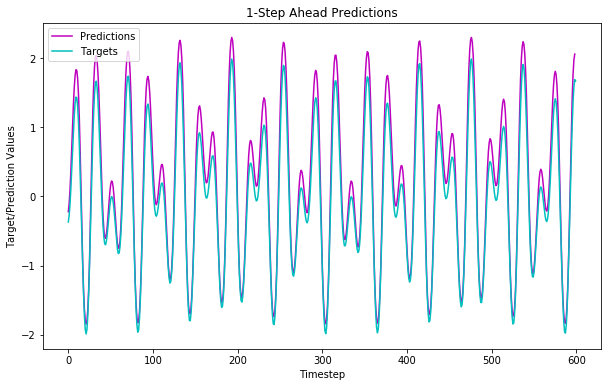

0.1415304889066693


In [51]:
#--------Testing Sine------------------
#1-step ahead prediction with a 60/20/20 split,flag is 2 because we're testing the model
sin_test = run(sin2, 40,30,30,int(Nr[1]),lam[1],2,1)
fig = plt.figure(figsize=(10, 6))
plt.title('1-Step Ahead Predictions')
plt.plot(sin_test[0], c='m', label='Predictions')
plt.plot(sin_test[1], c='c', label='Targets')
plt.xlabel('Timestep')
plt.ylabel('Target/Prediction Values')
plt.legend()
plt.show()
#calculate mean-square error
print(MSE(sin_test[0],sin_test[1],1))

### 1-Step Ahead Prediction
The above graph depicts the model after 1-step ahead prediction. After the prediction is calculated, we can use the predictions and targets to determine the model error using the mean-square error. This model, using data from the 2Sine dataset, has a mean-square error of 0.1415304889066693. From the error and graph we can see that the model generalizes well and 1-step ahead prediction gives values very close to the actual testing data.

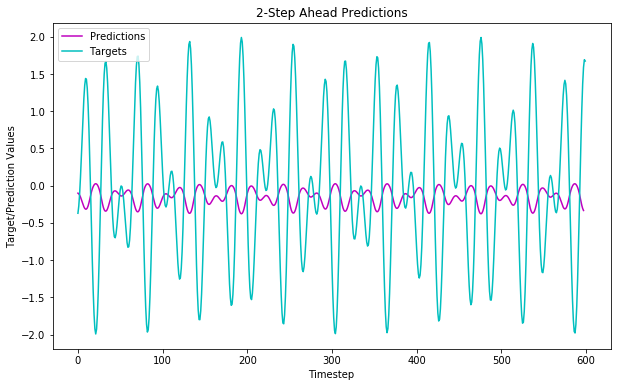

1.2372549272111728


In [52]:

#2-step ahead prediction with a 60/20/20 split,flag is 2 because we're testing the model
sin_test = run(sin2, 40,30,30,int(Nr[1]),lam[1],2,2)
fig = plt.figure(figsize=(10, 6))
plt.title('2-Step Ahead Predictions')
plt.plot(sin_test[0], c='m', label='Predictions')
plt.plot(sin_test[1], c='c', label='Targets')
plt.xlabel('Timestep')
plt.ylabel('Target/Prediction Values')
plt.legend()
plt.show()
#calculate mean-square error
print(MSE(sin_test[0],sin_test[1],2))

### 2-Step Ahead Prediction
The above graph shows the 2-step ahead predictions generated by the model. The predictions generated and the testing data are used to calculate the mean-square error: 1.2372549272111728. While slightly higher than the 1-step ahead prediction error, it is still fairly low. Comparing the graphs, it seems like the 2-step prediction graph is a compressed version of the 1-step ahead prediction graph. It makes sense that these predictions are less accurate, as error compounds overtime and to predict k-steps ahead, we need to use predictions in our state calculations.

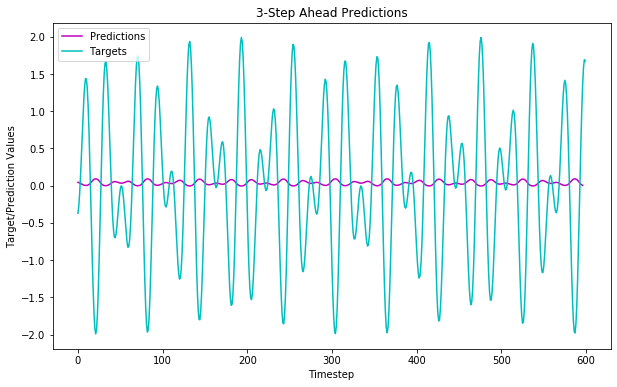

1.0568433563593274


In [53]:

#3-step ahead prediction with a 60/20/20 split,flag is 2 because we're testing the model
sin_test = run(sin2, 40,30,30,int(Nr[1]),lam[1],2,3)
fig = plt.figure(figsize=(10, 6))
plt.title('3-Step Ahead Predictions')
plt.plot(sin_test[0], c='m', label='Predictions')
plt.plot(sin_test[1], c='c', label='Targets')
plt.xlabel('Timestep')
plt.ylabel('Target/Prediction Values')
plt.legend()
plt.show()
#calculate mean-square error
print(MSE(sin_test[0],sin_test[1],3))

### 3-Step Ahead Prediction
The graph above shows the 3-step ahead predictions of the testing data. Once predictions are generated, the mean-square error is calculated using the predictions and the testing data to get 1.0568433563593274 This error is larger than both the 2-step and 1-step predictions, yet it is rather close to the 2-step prediction error. Visually, the 2-step and 3-step prediction graphs look similar, suggesting that the compounded error overtime is a similar amount for each prediction set.

## Results: Lorenz Timeseries Data

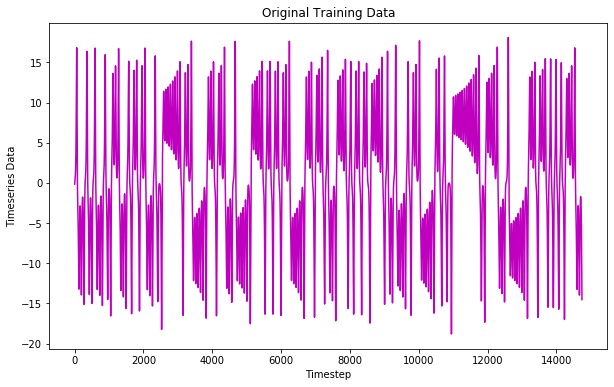

1

In [54]:

#-----------LORENZ EXPERIMENT-----------------------
lorenz = np.loadtxt('lorenz.txt')
#_lambda = 0.001
#start with a 60/20/20 split, 20 hidden neurons, 0.1 regression parameter, 0 step ahead
run(lorenz, 90,5,5,20,0.1,0,0)

### Evaluation of Trained Model
The model is trained using 20 hidden neurons and a regression parameter of 0.1.

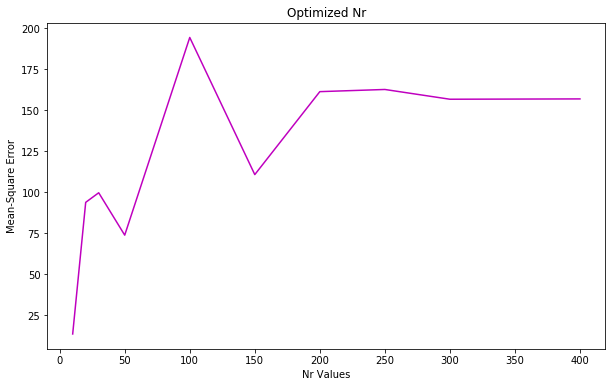

All tuples for Nr optimization:  [[ 13.65596573  10.        ]
 [ 93.80753482  20.        ]
 [ 99.64600792  30.        ]
 [ 73.84186176  50.        ]
 [194.21655249 100.        ]
 [110.70986585 150.        ]
 [161.22503185 200.        ]
 [162.54751508 250.        ]
 [156.60359857 300.        ]
 [156.79913239 400.        ]]
Best Nr value:  10


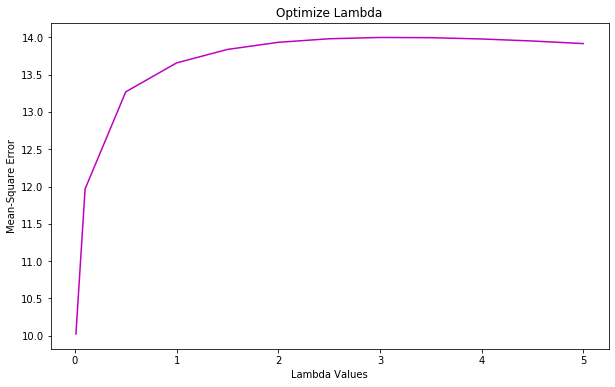

All tuples for lambda optimization:  [[1.00241973e+01 1.00000000e-02]
 [1.19672398e+01 1.00000000e-01]
 [1.32684060e+01 5.00000000e-01]
 [1.36559657e+01 1.00000000e+00]
 [1.38363972e+01 1.50000000e+00]
 [1.39317535e+01 2.00000000e+00]
 [1.39794047e+01 2.50000000e+00]
 [1.39968160e+01 3.00000000e+00]
 [1.39938467e+01 3.50000000e+00]
 [1.39766678e+01 4.00000000e+00]
 [1.39493935e+01 4.50000000e+00]
 [1.39148826e+01 5.00000000e+00]]
Best lambda value:  0.01
8.695383051743585
9.571560549427508
10.02419730123153
9.149368113093015
7.120149232235755
7.896501488703342


In [55]:

#Validate model: optimize hyperparameters
#optimized = run(lorenz,98,1,1,20,0.1,1,0)
#print(optimized)
pre_nr = [10,20,30,50,100,150,200,250,300,400]
tuples = optimizeNr(pre_nr,lorenz,1,1)
print('All tuples for Nr optimization: ',tuples)
#tuples = r_nr[0]
#sort tuples asc
Nr = tuples[search(tuples)]
print('Best Nr value: ',int(Nr[1]))
#optimize lambda
alpha = [0.01,0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
tuples = optimizel(alpha,lorenz,int(Nr[1]),1)
print('All tuples for lambda optimization: ',tuples)
#sort tuples asc
lam = tuples[search(tuples)]
print('Best lambda value: ',lam[1])
#optimize data split using optimized Nr and _lambda - flag is 3
a = run(lorenz,40,30,30,int(Nr[1]),lam[1],1,1)
print( MSE(a[0],a[1],1))
b = run(lorenz,50,30,20,int(Nr[1]),lam[1],1,1)
print( MSE(b[0],b[1],1))
c = run(lorenz,60,20,20,int(Nr[1]),lam[1],1,1)
print( MSE(c[0],c[1],1))
d = run(lorenz,70,15,15,int(Nr[1]),lam[1],1,1)
print( MSE(d[0],d[1],1))
e = run(lorenz,80,10,10,int(Nr[1]),lam[1],1,1)
print( MSE(e[0],e[1],1))
f = run(lorenz,90,5,5,int(Nr[1]),lam[1],1,1)
print(MSE(f[0],f[1],1))


### Evaluation of Cross-Validation
#### Optimizing Nr
The possible Nr values are [10,20,30,50,100,150,200,250,300,400]. When Nr is optimized, we get the following tuples (e, Nr) returned:   
[[ 13.65596573  10.        ]   
 [ 93.80753482  20.        ]   
 [ 99.64600792  30.        ]   
 [ 73.84186176  50.        ]   
 [194.21655249 100.        ]   
 [110.70986585 150.        ]   
 [161.22503185 200.        ]   
 [162.54751508 250.        ]   
 [156.60359857 300.        ]   
 [156.79913239 400.        ]]
We can see from both the graph and the above tuples that the optimal number of hidden layer neurons is 10 as it has the lowest associated mean-square error. There is a positive correlation between Nr and mean-square error.
#### Optimizing Regularization Parameter (lambda)
The possible lambda values are [0.01,0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]. When lambda is optimized, the following tuples (e,lambda) are returned:
[[1.00241973e+01 1.00000000e-02]   
 [1.19672398e+01 1.00000000e-01]   
 [1.32684060e+01 5.00000000e-01]   
 [1.36559657e+01 1.00000000e+00]   
 [1.38363972e+01 1.50000000e+00]   
 [1.39317535e+01 2.00000000e+00]   
 [1.39794047e+01 2.50000000e+00]   
 [1.39968160e+01 3.00000000e+00]   
 [1.39938467e+01 3.50000000e+00]   
 [1.39766678e+01 4.00000000e+00]   
 [1.39493935e+01 4.50000000e+00]   
 [1.39148826e+01 5.00000000e+00]]
 Looking at the graph and tuples, it can be determined that 0.01 is the optimal lambda which makes sense since the lorenz function is quite complex. Again, there is a relationship between mean-square error and lambda, but since the graph isn't linear, they are not correlated.
#### Optimizing the Amount of Training Data

The **run()** function is called on different splits and the associated mean-square error is printed out. Note that the optimized Nr and lambda are being used.
| Training/Validation/Testing --> Mean-Square Error|    
| 40/30/30 -------------------> 8.695383051743585  |   
| 50/30/20 -------------------> 9.571560549427508  |   
| 60/20/20 -------------------> 10.02419730123153  |   
| 70/15/15 -------------------> 9.149368113093015  |   
| 80/10/10 -------------------> 7.120149232235755  |   
| 90/5/5   -------------------> 7.896501488703342  |   

Based on the table, we can see that the 80/10/10 split has the lowest mean-square error. This is a much higher amount of training data than in the 2sine data, but this is likely because the lorenz function is much more complex, leading to a greater amount of data needed for training.

### Evaluation of K-Step Ahead Prediction

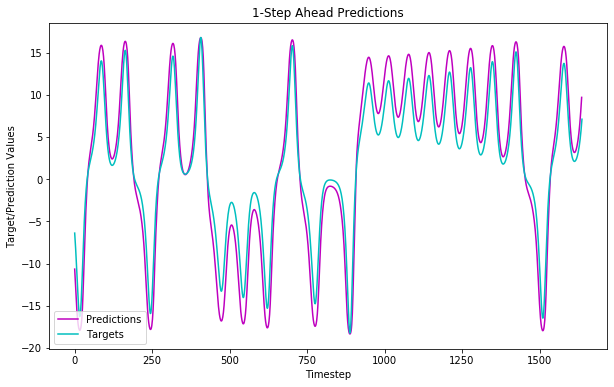

7.625808165920678


In [56]:

#Test again - flag is 2
lorenz_test = run(lorenz,80,10,10,int(Nr[1]),lam[1],2,1)
#Test on multiple k-steps
#Graph the data+prediction
#calculate mse
#predic = getTargets(lorenz_test[0],1)
#targets = getTargets(lorenz_test[1],1)

fig = plt.figure(figsize=(10, 6))
plt.title('1-Step Ahead Predictions')
plt.plot(lorenz_test[0], c='m', label='Predictions')
plt.plot(lorenz_test[1], c='c', label='Targets')
plt.xlabel('Timestep')
plt.ylabel('Target/Prediction Values')
plt.legend()
plt.show()
print(MSE(lorenz_test[0],lorenz_test[1],1))

### 1-Step Ahead Prediction
The above graph shows the 1-step ahead predictions and the actual testing data. Once the predictions are generated, we calculated the mean-square error to be 7.625808165920678. Looking at the lorenz data, it seems that the data varies more than the 2sine data and this could be a reason for a higher mean-square error. Visually, the predictions and the targets look very similar and we can conclude that the 1-step ahead predictions are fairly accurate.

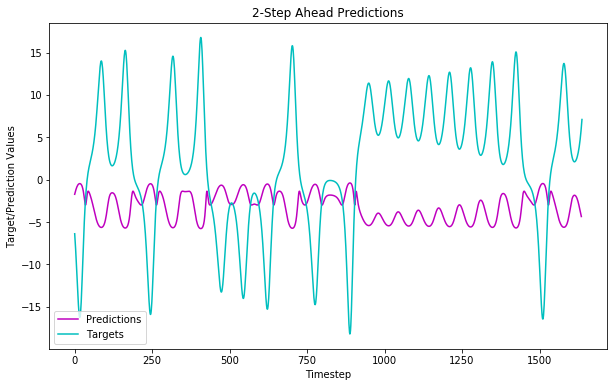

111.61124602041339


In [57]:

lorenz_test = run(lorenz,80,10,10,int(Nr[1]),lam[1],2,2)

fig = plt.figure(figsize=(10, 6))
plt.title('2-Step Ahead Predictions')
plt.plot(lorenz_test[0], c='m', label='Predictions')
plt.plot(lorenz_test[1], c='c', label='Targets')
plt.xlabel('Timestep')
plt.ylabel('Target/Prediction Values')
plt.legend()
plt.show()
print(MSE(lorenz_test[0],lorenz_test[1],2))

### 2-Step Ahead Prediction
Above is the graph of 2-step ahead predictions with the testing data. The mean-square error calculated using the predictions and targets is much higher than in the previous 1-step ahead prediction, 111.61124602041339. Similarly to the 2-step ahead predictions using the 2sine data, the predictions appear to be a compressed version of the 1-step ahead predictions. Again, I think this is caused by error compounding overtime since the predictions are being used to calculate the states.


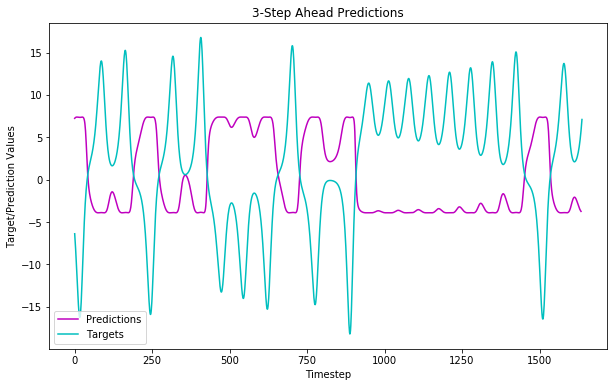

148.76019887760748


In [58]:
lorenz_test = run(lorenz,80,10,10,int(Nr[1]),lam[1],2,3)

fig = plt.figure(figsize=(10, 6))
plt.title('3-Step Ahead Predictions')
plt.plot(lorenz_test[0], c='m', label='Predictions')
plt.plot(lorenz_test[1], c='c', label='Targets')
plt.xlabel('Timestep')
plt.ylabel('Target/Prediction Values')
plt.legend()
plt.show()
print(MSE(lorenz_test[0],lorenz_test[1],3))

### 3-Step Ahead Prediction
Above is the graph of 3-step ahead predictions and testing data. The mean-square error generated using the predictions and targets is 148.76019887760748, which quite a bit larger than the error from the 2-step ahead predictions. Since the error is compounded overtime (because of the predictions being used in the state calculations) and because the lorenz data is greater and more varied, the overall error of the predictions is greater. Additionally, the predictions are less regularized so the affect of outliers on weight optimization greatly impacts the overall error.

## Final Observations
* The goal was to create a supervised prediction model where input closely resembles the target values. As seen in the 1-step predictions for both the 2Sine and Lorenz datasets, the predicted values are very close to the actual values. Since the model was trained using the training data, we can say that the model generalizes well because it works on the testing data it had never seen before.
* Since this ESN has only 1 output dimension, it is a function $f \colon \mathbb{R}^d \to \mathbb{R}$ and its output is $x \in \mathbb{R}$
* In this ESN, there's 1 hidden layer. Each hidden neuron in that layer extracts features and maps them to a new space using activation functions. Using an activation function in the state calculation adds non-linearity to the model, but as this calculation is done in each hidden neuron it adds complexity to the model as the number of hidden layer neurons increases.
* Using ridge regression on the model penalizes overly complex solutions by adding the regularization parameter $\lambda$. This helps reduce any overfitting caused during weight optimization by reducing the magnitude of the weights. Additionally, since $\lambda > 0$ the matrix is guarenteed to be invertible.
* As we learned in class, increased model complexity leads to overfitting and a failure to generalize. Based on this, I think that it is easier for the 2Sine data to generalize since the function is less complex and data points have less variance. The lorenz data uses data points with high variance and its function is very complex, which implies a larger expected prediction error. Also for the lorenz data, the complexity of the function causes a small regularization parameter, which causes outliers to greatly affect the optimization of the weights.
* We can use the idea of the expected prediction error discussed in class and apply it to our model. Since the validation set and testing set are independent of each other, the mean-square error calculated for validation is independent of the mean-square error of the testing data. We can say then that the error found in the validation set is an optimistic estimate of the test error.
* K-step ahead prediction produces less accurate results the more steps ahead you try to predict, as demonstrated in both the 2sine and lorenz experiments. This is because in order to predict k-steps ahead, we need to use predictions instead of target data in our state calculation. So any error in the predictions used to generate those states compounds overtime, causing less accurate predictions. For 1-step ahead, the error in each prediction is small enough to allow the results to be fairly accurate. However in 2-step and 3-step (especially for the lorenz experiment), the error in each prediction affects the results enough to drastically affect the accuracy of the predictions. Following this observation, we can assume that it would remain true for subsequent k-step ahead (4-step, 5-step etc.) predictions.